In [1]:
from coco_utils import load_coco_data
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Load Data

[Microsoft COCO dataset](http://mscoco.org/) which has become the standard testbed for image captioning. The dataset consists of 80,000 training images and 40,000 validation images, each annotated with 5 captions written by workers on Amazon Mechanical Turk.

You should have already downloaded the data by changing to the `datasets` directory and running the script `get_assignment3_data.sh`. If you haven't yet done so, run that script now. Warning: the COCO data download is ~1GB.

We have preprocessed the data and extracted features for you already. For all images we have extracted features from the fc7 layer of the VGG-16 network pretrained on ImageNet; these features are stored in the files `train2014_vgg16_fc7.h5` and `val2014_vgg16_fc7.h5` respectively. To cut down on processing time and memory requirements, we have reduced the dimensionality of the features from 4096 to 512; these features can be found in the files `train2014_vgg16_fc7_pca.h5` and `val2014_vgg16_fc7_pca.h5`.

The raw images take up a lot of space (nearly 20GB) so we have not included them in the download. However all images are taken from Flickr, and URLs of the training and validation images are stored in the files `train2014_urls.txt` and `val2014_urls.txt` respectively. This allows you to download images on the fly for visualization. Since images are downloaded on-the-fly, **you must be connected to the internet to view images**.

Dealing with strings is inefficient, so we will work with an encoded version of the captions. Each word is assigned an integer ID, allowing us to represent a caption by a sequence of integers. The mapping between integer IDs and words is in the file `coco2014_vocab.json`, and you can use the function `decode_captions`  to convert numpy arrays of integer IDs back into strings.

There are a couple special tokens that we add to the vocabulary. We prepend a special `<START>` token and append an `<END>` token to the beginning and end of each caption respectively. Rare words are replaced with a special `<UNK>` token (for "unknown"). In addition, since we want to train with minibatches containing captions of different lengths, we pad short captions with a special `<NULL>` token after the `<END>` token and don't compute loss or gradient for `<NULL>` tokens. Since they are a bit of a pain, we have taken care of all implementation details around special tokens for you.

You can load all of the MS-COCO data (captions, features, URLs, and vocabulary) using the `load_coco_data` function from the file `coco_utils.py`. Run the following cell to do so:

In [2]:
# Load COCO data from disk; this returns a dictionary
# We'll work with dimensionality-reduced features for this notebook, but feel
# free to experiment with the original features by changing the flag below.
data = load_coco_data('datasets/coco_captioning', pca_features=True)

In [3]:
# Print out all the keys and values from the data dictionary
for k, v in data.items():
    if type(v) == np.ndarray:
        print('array', k, type(v), v.shape, v.dtype)
    else:
        print('not-array', k, type(v), len(v))

('not-array', u'idx_to_word', <type 'list'>, 1004)
('array', u'train_captions', <type 'numpy.ndarray'>, (400135, 17), dtype('int32'))
('array', u'val_captions', <type 'numpy.ndarray'>, (195954, 17), dtype('int32'))
('array', u'train_image_idxs', <type 'numpy.ndarray'>, (400135,), dtype('int32'))
('array', 'val_features', <type 'numpy.ndarray'>, (40504, 512), dtype('float32'))
('array', u'val_image_idxs', <type 'numpy.ndarray'>, (195954,), dtype('int32'))
('array', 'train_features', <type 'numpy.ndarray'>, (82783, 512), dtype('float32'))
('array', 'train_urls', <type 'numpy.ndarray'>, (82783,), dtype('S63'))
('array', 'val_urls', <type 'numpy.ndarray'>, (40504,), dtype('S63'))
('not-array', u'word_to_idx', <type 'dict'>, 1004)


In [4]:
# train_caption 去重之后就是 82783 个
print('train_captions: ', data['train_captions'].shape)
print('train_image_idxs: ', data['train_image_idxs'].shape)

print('train_features: ', data['train_features'].shape)
print('train_urls: ', data['train_urls'].shape)
print('val_captions: ', data['val_captions'].shape)
print('val_image_idxs: ', data['val_image_idxs'].shape)
print('val_features: ', data['val_features'].shape)
print('val_urls: ', data['val_urls'].shape)

('train_captions: ', (400135, 17))
('train_image_idxs: ', (400135,))
('train_features: ', (82783, 512))
('train_urls: ', (82783,))
('val_captions: ', (195954, 17))
('val_image_idxs: ', (195954,))
('val_features: ', (40504, 512))
('val_urls: ', (40504,))


In [5]:
import urllib, tempfile
from scipy.misc import imread, imresize

def sample_coco_minibatch(data, batch_size=100, split='train'):
    split_size = data['%s_captions' % split].shape[0]
    mask = np.random.choice(split_size, batch_size)
    captions = data['%s_captions' % split][mask]
    image_idxs = data['%s_image_idxs' % split][mask]
    image_features = data['%s_features' % split][image_idxs]
    urls = data['%s_urls' % split][image_idxs]
    return captions, image_features, urls

def image_from_url(url):    
    f = urllib.urlopen(url)
    _, fname = tempfile.mkstemp()
    with open(fname, 'wb') as ff:
        ff.write(f.read())
    img = imread(fname)
    return img

def decode_captions(captions, idx_to_word):
    singleton = False
    if captions.ndim == 1:
        singleton = True
        captions = captions[None]
    decoded = []
    N, T = captions.shape
    for i in range(N):
        words = []
        for t in range(T):
            word = idx_to_word[captions[i, t]]
            if word != '<NULL>':
                words.append(word)
            if word == '<END>':
                break
        decoded.append(' '.join(words))
    if singleton:
        decoded = decoded[0]
    return decoded


In [6]:
captions, features, urls = sample_coco_minibatch(data, batch_size=3)

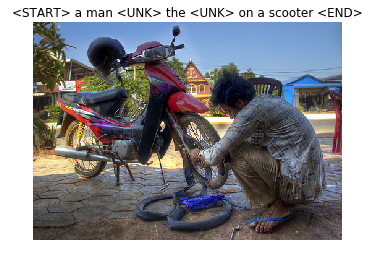

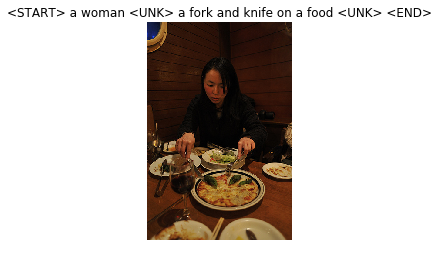

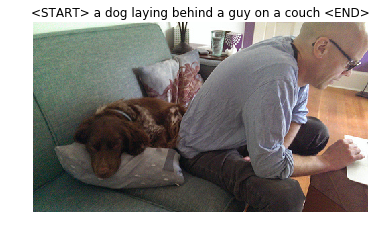

In [7]:
for i, (caption, url) in enumerate(zip(captions, urls)):
    plt.imshow(image_from_url(url))
    plt.axis('off')
    caption_str = decode_captions(caption, data['idx_to_word'])
    plt.title(caption_str)
    plt.show()

In [8]:
import optimizer
from deep_networks import *
from vanilla_lstm import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## rnn_lstm_net

![](img/caption_model.png)

In [9]:

class CaptioningRNN(object):
    """
    A CaptioningRNN produces captions from image features using a recurrent
    neural network.

    The RNN receives input vectors of size D, has a vocab size of V, works on
    sequences of length T, has an RNN hidden dimension of H, uses word vectors
    of dimension W, and operates on minibatches of size N.

    Note that we don't use any regularization for the CaptioningRNN.
    """

    def __init__(self, word_to_idx, input_dim=512, wordvec_dim=128,
                 hidden_dim=128, cell_type='rnn', dtype=np.float32):
        """
        Construct a new CaptioningRNN instance.

        Inputs:
        - word_to_idx: A dictionary giving the vocabulary. It contains V entries,
          and maps each string to a unique integer in the range [0, V).
        - input_dim: Dimension D of input image feature vectors.
        - wordvec_dim: Dimension W of word vectors.
        - hidden_dim: Dimension H for the hidden state of the RNN.
        - cell_type: What type of RNN to use; either 'rnn' or 'lstm'.
        - dtype: numpy datatype to use; use float32 for training and float64 for
          numeric gradient checking.
        """
        if cell_type not in {'rnn', 'lstm'}:
            raise ValueError('Invalid cell_type "%s"' % cell_type)

        self.cell_type = cell_type
        self.dtype = dtype
        self.word_to_idx = word_to_idx
        self.idx_to_word = {i: w for w, i in word_to_idx.items()}
        self.params = {}

        vocab_size = len(word_to_idx)

        self._null = word_to_idx['<NULL>']
        self._start = word_to_idx.get('<START>', None)
        self._end = word_to_idx.get('<END>', None)

        # Initialize word vectors
        self.params['W_embed'] = np.random.randn(vocab_size, wordvec_dim)
        self.params['W_embed'] /= 100

        # Initialize CNN -> hidden state projection parameters
        self.params['W_proj'] = np.random.randn(input_dim, hidden_dim)
        self.params['W_proj'] /= np.sqrt(input_dim)
        self.params['b_proj'] = np.zeros(hidden_dim)

        # Initialize parameters for the RNN
        dim_mul = {'lstm': 4, 'rnn': 1}[cell_type]
        self.params['Wx'] = np.random.randn(wordvec_dim, dim_mul * hidden_dim)
        self.params['Wx'] /= np.sqrt(wordvec_dim)
        self.params['Wh'] = np.random.randn(hidden_dim, dim_mul * hidden_dim)
        self.params['Wh'] /= np.sqrt(hidden_dim)
        self.params['b'] = np.zeros(dim_mul * hidden_dim)

        # Initialize output to vocab weights
        self.params['W_vocab'] = np.random.randn(hidden_dim, vocab_size)
        self.params['W_vocab'] /= np.sqrt(hidden_dim)
        self.params['b_vocab'] = np.zeros(vocab_size)

        # Cast parameters to correct dtype
        for k, v in self.params.items():
            self.params[k] = v.astype(self.dtype)


    def loss(self, features, captions):
        """
        Compute training-time loss for the RNN. We input image features and
        ground-truth captions for those images, and use an RNN (or LSTM) to compute
        loss and gradients on all parameters.

        Inputs:
        - features: Input image features, of shape (N, D)
        - captions: Ground-truth captions; an integer array of shape (N, T) where
          each element is in the range 0 <= y[i, t] < V

        Returns a tuple of:
        - loss: Scalar loss
        - grads: Dictionary of gradients parallel to self.params
        """
        # Cut captions into two pieces: captions_in has everything but the last word
        # and will be input to the RNN; captions_out has everything but the first
        # word and this is what we will expect the RNN to generate. These are offset
        # by one relative to each other because the RNN should produce word (t+1)
        # after receiving word t. The first element of captions_in will be the START
        # token, and the first element of captions_out will be the first word.
        captions_in = captions[:, :-1]
        captions_out = captions[:, 1:]

        # You'll need this
        mask = (captions_out != self._null)

        # Weight and bias for the affine transform from image features to initial
        # hidden state
        W_proj, b_proj = self.params['W_proj'], self.params['b_proj']

        # Word embedding matrix
        W_embed = self.params['W_embed']

        # Input-to-hidden, hidden-to-hidden, and biases for the RNN
        Wx, Wh, b = self.params['Wx'], self.params['Wh'], self.params['b']

        # Weight and bias for the hidden-to-vocab transformation.
        W_vocab, b_vocab = self.params['W_vocab'], self.params['b_vocab']

        loss, grads = 0.0, {}

        # FORWARD PASS.
        # Transform CNN image feature to be the initial hidden state.
        inital_hidden_state, cache_initial = affine_forward(features, W_proj, b_proj)

        # Embed the input word captions.
        embedded_captions, cache_word_embedding = word_embedding_forward(captions_in, W_embed)

        # Vanilla RNN or LSTM forward pass.
        if self.cell_type == 'rnn':
            rnn_outputs, cache_rnn = rnn_forward(embedded_captions, inital_hidden_state, Wx, Wh, b)
        elif self.cell_type == 'lstm':
            rnn_outputs, cache_rnn = lstm_forward(embedded_captions, inital_hidden_state, Wx, Wh, b)

        # Scores and loss.
        scores, cache_scores = temporal_affine_forward(rnn_outputs, W_vocab, b_vocab)
        loss, dsoftmax = temporal_softmax_loss(scores, captions_out, mask)

        # BACKWARD PASS.
        # Backprop dsoftmax to calculate gradient for W_vocab, b_vocab.
        dscores, dW_vocab, db_vocab = temporal_affine_backward(dsoftmax, cache_scores)
        grads['W_vocab'], grads['b_vocab'] = dW_vocab, db_vocab

        # Backprop dscores through the RNN module calculating all gradients.
        if self.cell_type == 'rnn':
            dx, dh0, dWx, dWh, db = rnn_backward(dscores, cache_rnn)
            grads['b'], grads['Wh'], grads['Wx'] = db, dWh, dWx
        elif self.cell_type == 'lstm':
            dx, dh0, dWx, dWh, db = lstm_backward(dscores, cache_rnn)
            grads['b'], grads['Wh'], grads['Wx'] = db, dWh, dWx

        # Backprop dx to get gradient for word embedding weights.
        dW_embed = word_embedding_backward(dx, cache_word_embedding)
        grads['W_embed'] = dW_embed

        # Backprop dh0 to get gradient for feature projection weights.
        dx_initial, dW_proj, db_proj = affine_backward(dh0, cache_initial)
        grads['W_proj'], grads['b_proj'] = dW_proj, db_proj

        return loss, grads


    def sample(self, features, max_length=30):
        """
        Run a test-time forward pass for the model, sampling captions for input
        feature vectors.

        At each timestep, we embed the current word, pass it and the previous hidden
        state to the RNN to get the next hidden state, use the hidden state to get
        scores for all vocab words, and choose the word with the highest score as
        the next word. The initial hidden state is computed by applying an affine
        transform to the input image features, and the initial word is the <START>
        token.

        For LSTMs you will also have to keep track of the cell state; in that case
        the initial cell state should be zero.

        Inputs:
        - features: Array of input image features of shape (N, D).
        - max_length: Maximum length T of generated captions.

        Returns:
        - captions: Array of shape (N, max_length) giving sampled captions,
          where each element is an integer in the range [0, V). The first element
          of captions should be the first sampled word, not the <START> token.
        """
        N = features.shape[0]
        captions = self._null * np.ones((N, max_length), dtype=np.int32)

        # Unpack parameters
        W_proj, b_proj = self.params['W_proj'], self.params['b_proj']
        W_embed = self.params['W_embed']
        Wx, Wh, b = self.params['Wx'], self.params['Wh'], self.params['b']
        W_vocab, b_vocab = self.params['W_vocab'], self.params['b_vocab']

        # Calculate initial hidden state h0 from our image features and learned transform.
        cur_hidden_state, _ = affine_forward(features, W_proj, b_proj)

        if self.cell_type == 'lstm':
            cur_cell_state = np.zeros_like(cur_hidden_state)

        # Embed our start token, will broadcast to size N.
        word_embed, _ = word_embedding_forward(self._start, W_embed)

        # Sample max_length number of words.
        for i in range(max_length):

            if self.cell_type == 'rnn':
                cur_hidden_state, _ = rnn_step_forward(word_embed, cur_hidden_state, Wx, Wh, b)
            elif self.cell_type == 'lstm':
                cur_hidden_state, cur_cell_state, _ = lstm_step_forward(word_embed, cur_hidden_state, cur_cell_state, Wx, Wh, b)

            # Scores for this current time step.
            cur_scores, _ = affine_forward(cur_hidden_state, W_vocab, b_vocab)

            # Find the highest value index and assign it to the correct place in captions.
            captions[:,i] = np.argmax(cur_scores, axis=1)

            # Embed the word produced for the next iteration.
            word_embed, _ = word_embedding_forward(captions[:, i], W_embed)

        return captions


## caption_solver

In [10]:
class CaptioningSolver(object):
    """
    A CaptioningSolver encapsulates all the logic necessary for training
    image captioning models. The CaptioningSolver performs stochastic gradient
    descent using different update rules defined in optim.py.

    The solver accepts both training and validataion data and labels so it can
    periodically check classification accuracy on both training and validation
    data to watch out for overfitting.

    To train a model, you will first construct a CaptioningSolver instance,
    passing the model, dataset, and various options (learning rate, batch size,
    etc) to the constructor. You will then call the train() method to run the
    optimization procedure and train the model.

    After the train() method returns, model.params will contain the parameters
    that performed best on the validation set over the course of training.
    In addition, the instance variable solver.loss_history will contain a list
    of all losses encountered during training and the instance variables
    solver.train_acc_history and solver.val_acc_history will be lists containing
    the accuracies of the model on the training and validation set at each epoch.

    Example usage might look something like this:

    data = load_coco_data()
    model = MyAwesomeModel(hidden_dim=100)
    solver = CaptioningSolver(model, data,
                    update_rule='sgd',
                    optim_config={
                      'learning_rate': 1e-3,
                    },
                    lr_decay=0.95,
                    num_epochs=10, batch_size=100,
                    print_every=100)
    solver.train()


    A CaptioningSolver works on a model object that must conform to the following
    API:

    - model.params must be a dictionary mapping string parameter names to numpy
      arrays containing parameter values.

    - model.loss(features, captions) must be a function that computes
      training-time loss and gradients, with the following inputs and outputs:

      Inputs:
      - features: Array giving a minibatch of features for images, of shape (N, D
      - captions: Array of captions for those images, of shape (N, T) where
        each element is in the range (0, V].

      Returns:
      - loss: Scalar giving the loss
      - grads: Dictionary with the same keys as self.params mapping parameter
        names to gradients of the loss with respect to those parameters.
    """

    def __init__(self, model, data, **kwargs):
        """
        Construct a new CaptioningSolver instance.

        Required arguments:
        - model: A model object conforming to the API described above
        - data: A dictionary of training and validation data from load_coco_data

        Optional arguments:
        - update_rule: A string giving the name of an update rule in optim.py.
          Default is 'sgd'.
        - optim_config: A dictionary containing hyperparameters that will be
          passed to the chosen update rule. Each update rule requires different
          hyperparameters (see optim.py) but all update rules require a
          'learning_rate' parameter so that should always be present.
        - lr_decay: A scalar for learning rate decay; after each epoch the learning
          rate is multiplied by this value.
        - batch_size: Size of minibatches used to compute loss and gradient during
          training.
        - num_epochs: The number of epochs to run for during training.
        - print_every: Integer; training losses will be printed every print_every
          iterations.
        - verbose: Boolean; if set to false then no output will be printed during
          training.
        """
        self.model = model
        self.data = data

        # Unpack keyword arguments
        self.update_rule = kwargs.pop('update_rule', 'sgd')
        self.optim_config = kwargs.pop('optim_config', {})
        self.lr_decay = kwargs.pop('lr_decay', 1.0)
        self.batch_size = kwargs.pop('batch_size', 100)
        self.num_epochs = kwargs.pop('num_epochs', 10)

        self.print_every = kwargs.pop('print_every', 10)
        self.verbose = kwargs.pop('verbose', True)

        # Throw an error if there are extra keyword arguments
        if len(kwargs) > 0:
            extra = ', '.join('"%s"' % k for k in list(kwargs.keys()))
            raise ValueError('Unrecognized arguments %s' % extra)

        # Make sure the update rule exists, then replace the string
        # name with the actual function
        if not hasattr(optimizer, self.update_rule):
            raise ValueError('Invalid update_rule "%s"' % self.update_rule)
        self.update_rule = getattr(optimizer, self.update_rule)

        self._reset()


    def _reset(self):
        """
        Set up some book-keeping variables for optimization. Don't call this
        manually.
        """
        # Set up some variables for book-keeping
        self.epoch = 0
        self.best_val_acc = 0
        self.best_params = {}
        self.loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []

        # Make a deep copy of the optim_config for each parameter
        self.optim_configs = {}
        for p in self.model.params:
            d = {k: v for k, v in self.optim_config.items()}
            self.optim_configs[p] = d


    def _step(self):
        """
        Make a single gradient update. This is called by train() and should not
        be called manually.
        """
        # Make a minibatch of training data
        minibatch = sample_coco_minibatch(self.data,
                      batch_size=self.batch_size,
                      split='train')
        captions, features, urls = minibatch

        # Compute loss and gradient
        loss, grads = self.model.loss(features, captions)
        self.loss_history.append(loss)

        # Perform a parameter update
        for p, w in self.model.params.items():
            dw = grads[p]
            config = self.optim_configs[p]
            next_w, next_config = self.update_rule(w, dw, config)
            self.model.params[p] = next_w
            self.optim_configs[p] = next_config


    # TODO: This does nothing right now; maybe implement BLEU?
    def check_accuracy(self, X, y, num_samples=None, batch_size=100):
        """
        Check accuracy of the model on the provided data.

        Inputs:
        - X: Array of data, of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,)
        - num_samples: If not None, subsample the data and only test the model
          on num_samples datapoints.
        - batch_size: Split X and y into batches of this size to avoid using too
          much memory.

        Returns:
        - acc: Scalar giving the fraction of instances that were correctly
          classified by the model.
        """
        return 0.0

        # Maybe subsample the data
        N = X.shape[0]
        if num_samples is not None and N > num_samples:
            mask = np.random.choice(N, num_samples)
            N = num_samples
            X = X[mask]
            y = y[mask]

        # Compute predictions in batches
        num_batches = N / batch_size
        if N % batch_size != 0:
            num_batches += 1
        y_pred = []
        for i in range(num_batches):
            start = i * batch_size
            end = (i + 1) * batch_size
            scores = self.model.loss(X[start:end])
            y_pred.append(np.argmax(scores, axis=1))
        y_pred = np.hstack(y_pred)
        acc = np.mean(y_pred == y)

        return acc


    def train(self):
        """
        Run optimization to train the model.
        """
        num_train = self.data['train_captions'].shape[0]
        iterations_per_epoch = max(num_train // self.batch_size, 1)
        num_iterations = self.num_epochs * iterations_per_epoch

        for t in range(num_iterations):
            self._step()

            # Maybe print training loss
            if self.verbose and t % self.print_every == 0:
                print('(Iteration %d / %d) loss: %f' % (
                       t + 1, num_iterations, self.loss_history[-1]))

            # At the end of every epoch, increment the epoch counter and decay the
            # learning rate.
            epoch_end = (t + 1) % iterations_per_epoch == 0
            if epoch_end:
                self.epoch += 1
                for k in self.optim_configs:
                    self.optim_configs[k]['learning_rate'] *= self.lr_decay

            # Check train and val accuracy on the first iteration, the last
            # iteration, and at the end of each epoch.
            # TODO: Implement some logic to check Bleu on validation set periodically

        # At the end of training swap the best params into the model
        # self.model.params = self.best_params

In [13]:
np.random.seed(231)

small_data = load_coco_data('datasets/coco_captioning', max_train=50)

small_rnn_model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=256,
        )

small_rnn_solver = CaptioningSolver(small_rnn_model, small_data,
           update_rule='adam',
           num_epochs=50,
           batch_size=25,
           optim_config={
             'learning_rate': 5e-3,
           },
           lr_decay=0.95,
           verbose=True, print_every=10,
         )

small_rnn_solver.train()

(Iteration 1 / 100) loss: 79.551150
(Iteration 11 / 100) loss: 39.988027
(Iteration 21 / 100) loss: 26.368980
(Iteration 31 / 100) loss: 14.062517
(Iteration 41 / 100) loss: 8.842346
(Iteration 51 / 100) loss: 5.115294
(Iteration 61 / 100) loss: 3.885764
(Iteration 71 / 100) loss: 3.030852
(Iteration 81 / 100) loss: 2.747632
(Iteration 91 / 100) loss: 1.978432


## test

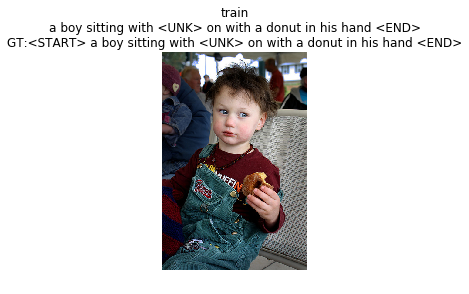

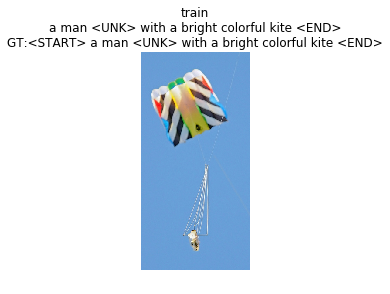

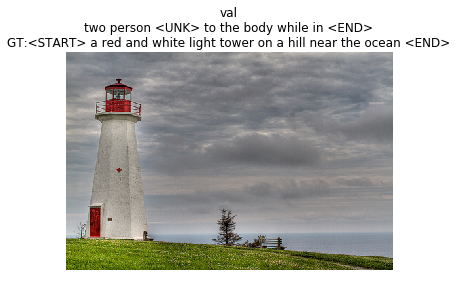

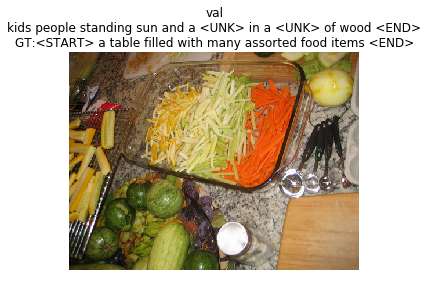

In [12]:
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = small_rnn_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        plt.imshow(image_from_url(url))
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()